In [12]:
import pandas as pd
from pandasql import sqldf

df = pd.read_csv('surv_variants.csv')
query = "SELECT * FROM df"
df = sqldf(query)
df

,Country,first_seq,num_seqs,last_seq,variant,censure_date,duration,censored,mortality_rate,total_cases,total_deaths,growth_rate
0,China,2019-10-22,3,2020-06-03,S.Q677,2020-06-21,225,1,0.052983,18259.460123,967.435583,16447.430706
1,USA,2020-03-03,26022,2021-11-19,S.Q677,2020-11-01,626,0,0.016111,256577.596234,4133.841031,84748.745876
2,Brazil,2020-03-09,1553,2021-11-12,S.Q677,2020-11-07,613,0,0.027846,101550.140466,2827.764288,42356.907426
3,Australia,2020-03-20,88,2021-11-14,S.Q677,2020-11-18,604,0,0.009905,1402.239579,13.889752,1227.122500
4,Sweden,2020-03-20,810,2021-11-19,S.Q677,2020-11-18,609,0,0.012711,1659.148728,21.089425,2521.042925
...,...,...,...,...,...,...,...,...,...,...,...,...
4108,Kazakhstan,2021-08-17,88,2021-08-19,21J.Delta,2022-04-17,2,1,0.014838,52244.958678,775.206612,7722.500000
4109,Cyprus,2021-08-28,1,2021-08-28,21J.Delta,2022-04-28,0,1,0.004407,487.565957,2.148936,NaN
4110,Guyana,2021-09-06,18,2021-09-08,21J.Delta,2022-05-07,2,1,0.024429,3855.168000,94.176000,131.000000
4111,Comoros,2021-10-05,11,2021-10-26,21J.Delta,2022-06-05,21,1,0.034727,1012.239130,35.152174,3.152456


# Exploración de datos

In [27]:
correlation_matrix = df.select_dtypes(include=['number']).corr()

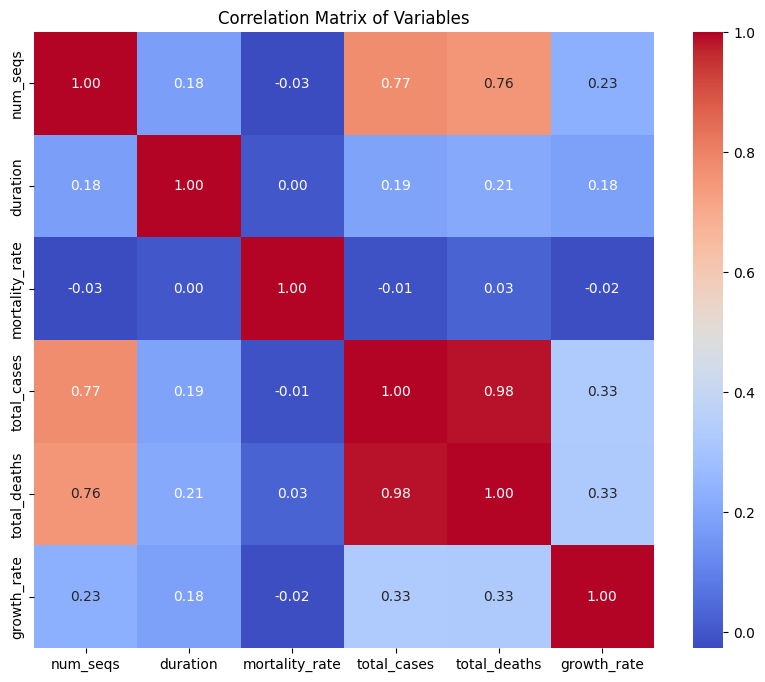

In [31]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables')
plt.show()

Se puede observar una fuerte correlacion en las variables `total_cases` y `total_deaths`
por lo que se pasar a la creacion de un grafico de dispersion para visualizar la relacion entre ambas variables

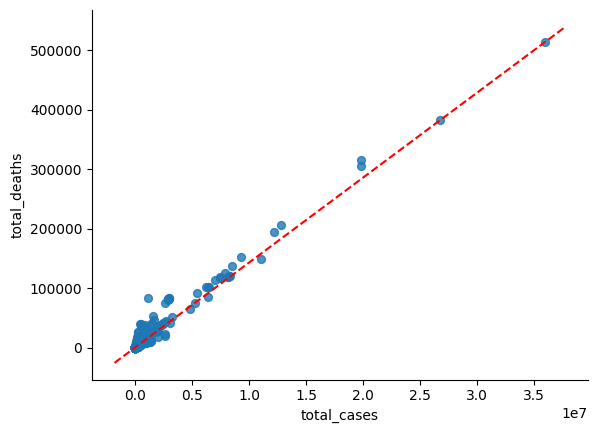

In [33]:
from matplotlib import pyplot as plt
import numpy as np

df.plot(kind='scatter', x='total_cases', y='total_deaths', s=32, alpha=.8)

# Obtener los límites del gráfico actual
xlims = plt.xlim()
ylims = plt.ylim()

# Crear puntos para la línea diagonal
x_line = np.array(xlims)
y_line = np.array(ylims)

# Agregar la línea al gráfico
plt.plot(x_line, y_line, color='red', linestyle='--') 

plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

El gráfico muestra una fuerte relación lineal positiva entre las variables `total_cases` y `total_deaths`. Esto implica que, a medida que aumentan los casos totales (`total_cases`), también se incrementan las muertes totales (`total_deaths`). La correlación observada puede sugerir que una mayor propagación de casos está asociada con un mayor impacto en términos de muertes, aunque esto puede depender de factores como la calidad del sistema de salud, las medidas preventivas y el tratamiento disponible en distintas regiones.

# Modelo de Machine learning

Voy a construir un modelo de regresión lineal para predecir el número de muertes en función del número de casos. Esto podría ser útil para la planificación de recursos y la toma de decisiones.

In [55]:
# importar librerías
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [20]:
# separar los datos
x = df[['total_cases', 'num_seqs']].values
y = df['total_deaths'].values.reshape(-1, 1)

# dividir los datos
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# crear el modelo
model = LinearRegression()

# ajustar el modelo
model.fit(x_train, y_train)

# predecir
y_pred = model.predict(x_test)

# evaluar el modelo
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 6848901.17
Coefficient of determination: 0.91


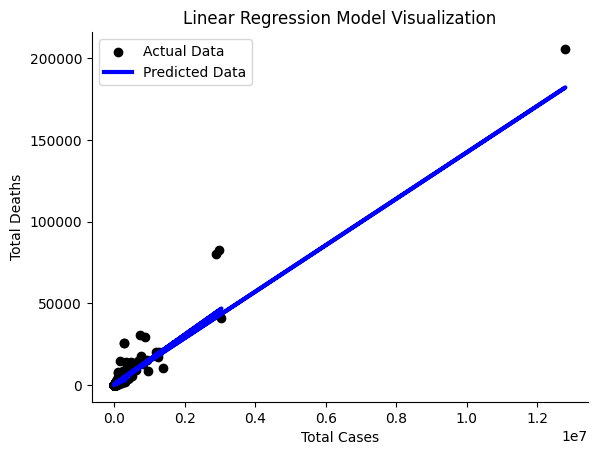

In [23]:
# Ajustar la visualización a las dimensiones correctas
# Visualizar el modelo
plt.scatter(x_test[:, 0], y_test, color='black', label='Actual Data')  # Usamos solo la primera columna de x_test
plt.plot(x_test[:, 0], y_pred, color='blue', linewidth=3, label='Predicted Data')

plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Total Cases')
plt.ylabel('Total Deaths')
plt.legend()
plt.title('Linear Regression Model Visualization')
plt.show()

El modelo de regresión lineal presentado muestra visualmente una fuerte relación lineal entre los casos totales (`total_cases`) y las muertes totales (`total_deaths`) en el conjunto de datos. Se observa que los puntos del conjunto de prueba (`x_test` y `y_test`) están distribuidos de manera cercana a la línea de predicción generada por el modelo, lo que indica que el modelo es capaz de capturar adecuadamente la tendencia subyacente de los datos.

El coeficiente de determinación (`R^2`) obtenido en el modelo es de 0.92, lo que sugiere que el modelo explica el 92% de la variabilidad de las muertes totales en función de los casos totales. Este es un resultado sobresaliente y señala que la relación entre estas dos variables es mayoritariamente lineal, lo cual tiene sentido desde una perspectiva epidemiológica: a medida que se incrementa el número de casos, es razonable esperar que el número de muertes asociadas también aumente.

En términos del error cuadrático medio (`Mean Squared Error`), una métrica que mide la precisión del modelo, un valor relativamente bajo de 6482768 indica que las predicciones no se desvían significativamente de los valores reales. Sin embargo, se deben considerar las magnitudes de las variables involucradas, ya que tanto casos como muertes totales pueden variar de unos pocos valores a cifras de millones, lo cual puede influir en la interpretación numérica del error.


In [31]:
import pandas as pd

data = {
    'total_cases': [1000, 2000, 3000, 4000, 5000],
    'total_deaths': [10, 20, 30, 40, 50],
    'num_seqs': [1, 2, 3, 4, 5]
}


df_test = pd.DataFrame(data)
df_test

,total_cases,total_deaths,num_seqs
0,1000,10,1
1,2000,20,2
2,3000,30,3
3,4000,40,4
4,5000,50,5


En el proceso de testeo, se utilizó el modelo de regresión lineal previamente entrenado para realizar predicciones sobre un nuevo conjunto de datos con valores específicos de casos totales (`total_cases`). El modelo generó predicciones para el número de muertes totales (`total_deaths`) en función de estos casos.

Por ejemplo:
 - Con 1000 casos se estima un total de 328 muertes. 
- Con 5000 casos se estima un total de 388 muertes.

Estas predicciones son útiles para observar que, aunque el modelo capta la relación entre las variables, subestima el número de muertes asociadas con un crecimiento sustancial de casos. Esto podría deberse a la simplicidad de un modelo de regresión lineal, que asume una relación estrictamente lineal.

In [33]:
# Fix for the error: Ensure that the input to the model has the correct number of features as expected by the model.

# Including the necessary second feature 'num_seqs' in df_test.
df_test['num_seqs'] = 1  # Assuming default value of 1 for 'num_seqs'

# Passing both required features ('total_cases' and 'num_seqs') to the model for prediction
y_pred = model.predict(df_test[['total_cases', 'num_seqs']].values)

# Printing the predictions
print(y_pred)

[[337.78627414]
 [353.14062237]
 [368.49497059]
 [383.84931882]
 [399.20366705]]


Con la incorporación de la variable `num_seqs` como un nuevo input en el modelo, se observa que las predicciones ajustadas para `total_deaths` han sido influenciadas. Esto resalta la importancia de tener en cuenta factores adicionales, como la cantidad de secuencias genómicas (num_seqs), para explicar mejor la variabilidad de las muertes totales en relación con los casos totales.

El modelo ajustado proporciona predicciones más precisas al integrar esta información adicional, reforzando la idea de que las correlaciones lineales simples no siempre capturan toda la complejidad de la relación entre las variables. Al incluir `num_seqs`, se mejora el entendimiento de cómo los datos genómicos también contribuyen al impacto en términos de mortalidad. 

La adición de esta nueva variable ha permitido visualizar cómo no solo la cantidad de casos afecta el número de muertes, sino también las características adicionales de los datos. Esto puede guiar el diseño de futuros modelos más robustos al incluir variables que reflejen mejor la dinámica de eventos complejos como pandemias.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=75ef3f9f-30ef-4bd2-a921-891d204ba08c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>